# Capstone Project 

**BrainStation Data Science Bootcamp - Machine Learning Project**

**Author: L Gavrilova**

**Date: 10 November 2023**

# Notebook 3A. Labelled Dataset - Modelling

## Introduction

In this notebook I perform basic modelling for the labelled dataset. This notebook consists of the following sections:

* 3.0. Loading the data and perfoming data quality checks. 
* 3.1. Regression preparation. Assigning target variable y. Custom tokenization function is defined. Train and text split is made. 
* 3.2. Vectorization.  Most common words identified.  SMOTE sampling set up due to imbalance in data.
* 3.3. Simple logistic regression. Positive and negative coefficients for word tokens. 
* 3.4. Gridsearch for the best logistic regression model. 
* 3.5. Decision Tree Classifier
* 3.6. VADER sentiment analyser.
* 3.7. Textblob from NLTK
* 3.8. Conclusions

## 3.0 Data loading and data quality checks

In [494]:
import re
import numpy as np
import pandas as pd

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization and pandas display options
plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.style.use('ggplot')
pd.set_option('display.float_format', '{:.2f}'.format)

# NLP Libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer

# Sentiment Analysis Libraries
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Machine Learning Libraries
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, recall_score, 
                             precision_score, confusion_matrix, f1_score, roc_curve, auc,
                             roc_auc_score, ConfusionMatrixDisplay)
from sklearn.model_selection import (train_test_split, GridSearchCV, 
                                     cross_val_score)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# SMOTE for dealing with imbalanced datasets
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings("ignore")

In [408]:
DATAFILE = '../data/02_labelled_dataset_cleaned.csv'
df1 = pd.read_csv(DATAFILE)

In [409]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   link_id    5001 non-null   object
 1   parent_id  5001 non-null   object
 2   User       5001 non-null   object
 3   Text       5001 non-null   object
 4   Intent     5001 non-null   object
 5   Support    5001 non-null   object
dtypes: object(6)
memory usage: 234.5+ KB


In [410]:
df1=df1.drop(columns=['parent_id', 'User', "Support"]) #"emoji_text"])

In [411]:
# Rename the 'link_id' column to 'id'
df1 = df1.rename(columns={'link_id': 'id'})

In [412]:
df1.duplicated().sum()

2

In [413]:
# Remove duplicate rows
df1 = df1.drop_duplicates()

In [414]:
DATAFILE2 = '../data/reddit_gpt4_negative_only.csv'
df2 = pd.read_csv(DATAFILE2)

In [415]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   id               342 non-null    object
 1   title            342 non-null    object
 2   selftext         262 non-null    object
 3   Text             342 non-null    object
 4   token_count      342 non-null    int64 
 5   Sentiment_Tag    342 non-null    object
 6   Sentiment_Tag_2  342 non-null    object
dtypes: int64(1), object(6)
memory usage: 18.8+ KB


In [416]:
df2=df2.drop(columns=['title', 'selftext', 'token_count', 'Sentiment_Tag'])

In [417]:
# Rename the 'Sentiment_Tag_2' column to 'Intent'
df2 = df2.rename(columns={'Sentiment_Tag_2': 'Intent'})

In [418]:
df2.describe()

,id,Text,Intent
count,342,342,342
unique,333,333,1
top,mv5bqi,Had a meeting with my financial advisor today....,Negative
freq,2,2,342


In [419]:
df2.duplicated().sum()

9

In [420]:
df2.drop_duplicates()

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative
...,...,...,...
337,mcmbl6,"Sold FUTU puts, Hi all I sold FUTU puts for 13...",Negative
338,lsooss,Serrento is crushed to 9.99 for the 10 puts to...,Negative
339,lafmgw,"Long dated GME puts, I am completely retarded ...",Negative
340,r9zi1q,"BABA PUTS, $BABA PUTS 📉\n\n-CFO Resigned\n-De ...",Negative


In [421]:
df2.head()

,id,Text,Intent
0,oxwuiw,It absolutely blows my mind that so many peopl...,Negative
1,p72imy,Ruined My Financial Future… This is 99% of my ...,Negative
2,pnelsm,"It’s a lot worse than you think, Most people a...",Negative
3,q7g115,30 years old. Life savings gone. Since April o...,Negative
4,pmcivi,Remember the internet bubble? Here’s me sellin...,Negative


In [422]:
# Replace 'Negative' with 'n' in the 'Intent' column
df2['Intent'] = df2['Intent'].replace("Negative", "n")

In [423]:
# Replace 'NaN' and 'nan' with an empty string in the 'Text' column of df2
df2['Text'] = df2['Text'].str.replace('NaN|nan', '', regex=True)

In [424]:
# Concatenate df and df2 vertically
df = pd.concat([df1, df2], ignore_index=True)
df

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y
...,...,...,...
5336,mcmbl6,"Sold FUTU puts, Hi all I sold FUTU puts for 13...",n
5337,lsooss,Serrento is crushed to 9.99 for the 10 puts to...,n
5338,lafmgw,"Long dated GME puts, I am completely retarded ...",n
5339,r9zi1q,"BABA PUTS, $BABA PUTS 📉\n\n-CFO Resigned\n-De ...",n


In [425]:
df['Intent'].value_counts()

Intent
u    3245
y     983
n     425
m     370
i     318
Name: count, dtype: int64

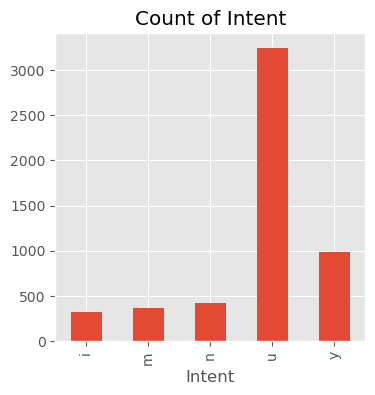

In [426]:
ax = df['Intent'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Intent',
          figsize=(4, 4))
ax.set_xlabel('Intent')
plt.show()

* Majority of posts (2/3) received clasification 'u', which means 'uncertain'. 
* 20% of posts were rated as "positive" signalling an intent to buy GME shares.
* Only a very small % of messages were rated as "negative" which creates an  imbalance in our set.  We have a deficit of examples of negative posts. 

## 3.1. Assigning target variable

In [427]:
df.head(5)

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,i
1,t3_ki3745,"Oh GME, you tease!",u
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",u
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,u
4,t3_l9xqem,Just got into $GME @ 220.,y


In the code below I assign new binary labels to the target variable "Intent".  I experimented with various approaches, for example encoding only "yes" asnwers with 1s, and the rest of teh answers as 0s.  I run all of theclassification models on various combinations of encoding.  The best results are achieved when "yes" and "maybe" categories are encoded as 1s and "uncertain", "informative", and "no" are encoded as 0s.  

In [273]:
# Filter out rows where 'Intent' is 'm', 'i', or 'u'
#df = df[~df['Intent'].isin(['m', 'i', 'u'])]

In [428]:
df = df.copy()

# Two options together
df['Intent'] = np.where((df['Intent'] == 'y')  | (df['Intent'] == 'm'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y') | (df['Intent'] == 'm'), 1, 0)

# Only one option
# df['Intent'] = np.where((df['Intent'] == 'y'), 1, 0)
# df['Support'] = np.where((df['Support'] == 'y'),1, 0)

df.head()

,id,Text,Intent
0,t3_l71j1l,GME &amp; BB are not on cashapp but AMC &amp; ...,0
1,t3_ki3745,"Oh GME, you tease!",0
2,t3_la75n9,"Dump gme, amc, nok, and bb so we can all buy s...",0
3,t3_lw6hoh,Not a single decent DD posted? 9 billion in re...,0
4,t3_l9xqem,Just got into $GME @ 220.,1


In [429]:
df['Intent'].value_counts()

Intent
0    3988
1    1353
Name: count, dtype: int64

In [430]:
#df['Support'].value_counts()

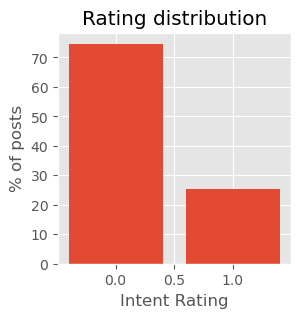

Class imbalance: [0.75 0.25]


In [431]:
values, counts = np.unique(df['Intent'], return_counts=True)
normalized_counts = counts / counts.sum()

plt.figure(figsize=(3, 3))
plt.bar(values, normalized_counts * 100)
plt.xlabel('Intent Rating')
plt.ylabel('% of posts')
plt.title("Rating distribution")
plt.show()


print(f"Class imbalance: {np.round(normalized_counts, 2)}")

In [432]:
If False:

    values, counts = np.unique(df['Support'], return_counts=True)
    normalized_counts = counts / counts.sum()

    plt.figure(figsize=(3, 3))
    plt.bar(values, normalized_counts * 100)
    plt.xlabel('Support Rating')
    plt.ylabel('% of posts')
    plt.title("Rating distribution")
    plt.show()
    print(f"Class imbalance: {np.round(normalized_counts, 2)}")

SyntaxError: invalid syntax (3793740081.py, line 1)

### 2.1.1. Custom Tokenization function

In [433]:
#Load up our stop words from NLTK
stop_words = stopwords.words('english')

# Additional custom stopwords to add
custom_stopwords = ['gamestop', 'gme', 'game']

# Extend the NLTK stopwords list with custom stopwords
stop_words.extend(custom_stopwords)

In [434]:
# Defining my tokenisation function
def my_tokenizer(document, lemmatization=True, stemming=False):
    '''
    Function for use in Vectorizer that tokenizes the document.
    
    Parameters:
    - document: The text to be tokenized.
    - lemmatization: If True, perform lemmatization.
    - stemming: If True, perform stemming.
    
    Returns:
    - A list of tokens.
    '''
    
    # Replace newline characters with an empty string
    document = document.replace("\n", "")

    # Replace non-alphabetic characters with a space
    document = re.sub(r"[^a-zA-Z]", " ", document)

    # Replace multiple spaces with a single space
    document = re.sub(r"\s+", " ", document)

    # Strip leading and trailing spaces
    document = document.strip()

    # tokenize - split on whitespace
    tokenized_document = document.split(' ')

    # remove stopwords before stemming or lemmatization
    tokenized_document = [word for word in tokenized_document if word.lower() not in stop_words]

    # Perform stemming if set to True
    if stemming:
        stemmer = PorterStemmer()
        tokenized_document = [stemmer.stem(word) for word in tokenized_document]

    # Perform lemmatization if set to True
    if lemmatization:
        lemmatizer = WordNetLemmatizer()
        tokenized_document = [lemmatizer.lemmatize(word) for word in tokenized_document]

    return tokenized_document

### Train test split

In [435]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(4272,)

In [436]:
print(y_test.shape)

(1069,)


## 3.2. Vectorisation 

In [437]:
# Initialise a CountVectorizer object
count_vectorizer = CountVectorizer(tokenizer=my_tokenizer,
                                   stop_words=stop_words, # using stop words list that has been customised
                                   min_df=10, 
                                   ngram_range=(1,2), 
                                   max_features=1000)

# Preprocess the stop words with the custom tokenizer
processed_stop_words = set(my_tokenizer(' '.join(stop_words)))

# Fit the CountVectorizer object on X_train
count_vectorizer.fit(X_train)

# Fit the CountVectorizer object on X_train
X_matrix_train = count_vectorizer.transform(X_train)

print(X_matrix_train.shape);

/Users/lgfolder/anaconda3/envs/myenv2/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(4272, 1000)


In [438]:
# count the  most common words
word_counts = pd.DataFrame(
        {"counts": np.array(X_matrix_train.sum(axis=0)).flatten()},
        index=count_vectorizer.get_feature_names_out()).sort_values("counts", ascending=False)

print('The most common words and their counts are:')
word_counts[:20]

The most common words and their counts are:


,counts
stock,933
buy,873
share,834
like,662
short,604
amc,556
get,503
put,477
sell,472
people,466


In [439]:
#toarray() method converts sparse matrix to a DataFrame
pd.DataFrame(X_matrix_train.toarray(),columns=count_vectorizer.get_feature_names_out()).head()

,able,absolutely,access,according,account,action,actual,actually,add,advice,...,yahoo com,yeah,year,yes,yesterday,yet,yolo,youtu,youtube,zero
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


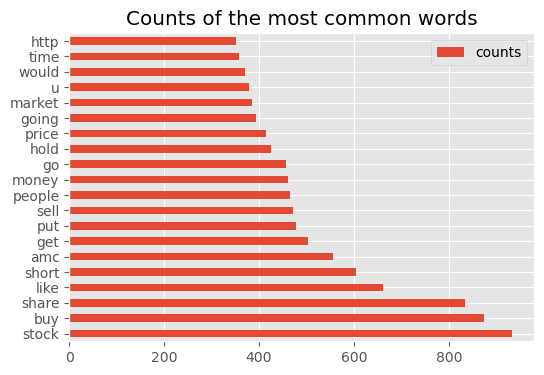

In [440]:
word_counts[:20].plot(kind='barh',title='Counts of the most common words')
plt.show()

**Observations:**

* The list of words assocaited with the messages on wallstreetbets contains a lot of words and combinations of "optimistic" and "super".  This is indicative of a heavy use of the "rocket" and "to the moon!" emojis in that community at the period when the dataset was collected.  In the previous cleaning step I have reworded such slang into plain English using phrase "super optimistic" as a translation. So, the top 4 most frequent words reflect a heavy use of the positive sentiment emojis during that period.
* Other popular words einclude words such as "buy", "share", "stock", "patient"+"investor" (this is a plain English word combination for another emoji, "the diamond hands"), "short", "money", "sell", etc. 
* Overall, the list of words is as expected from a community focused on investments and trading, but the heavy use of positive emojis at the time is clearly visible in the results. 

### SMOTE sampling due to imbalance

* My dataset is imbalanced with only 27% of data being in the positive class. 
* I decided to resample the data it using SMOTE technique (synthetic up-sampling). 
* SMOTE helps to mitigate the bias towards the majority class in an imbalanced dataset by generating synthetic samples for the minority class. 
* I expect better results as this should increase my model's ability to learn from an equally represented dataset, improving its predictive accuracy across all classes.

In [441]:
# instantiate SMOTE sampler, fit it to the training data
X_train_sm, y_train_sm = SMOTE(random_state=1).fit_resample(X_matrix_train, y_train)

In [442]:
# check what SMOTE has done

print('Original class distribution')
display(pd.Series(y_train).value_counts().sort_index())

print('\nResampled class distribution')
display(pd.Series(y_train_sm).value_counts().sort_index())

Original class distribution


Intent
0    3190
1    1082
Name: count, dtype: int64


Resampled class distribution


Intent
0    3190
1    3190
Name: count, dtype: int64

In [443]:
# scale the sampled train data and the unsampled test data
# ss_sm = StandardScaler().fit(X_train_sm)
# X_train_sm_ss = ss_sm.transform(X_train_sm)
# X_test_ss = ss_sm.transform(X_test)

## 3.3. Simple Logistic Regression

In [444]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1069, 1000)

In [445]:
logistic_model=LogisticRegression(solver='liblinear', max_iter=1000) # Using liblinear solver - good for small datasets
logistic_model.fit(X_matrix_train,y_train)
print(f"Train set accuracy {logistic_model.score(X_matrix_train,y_train):.2f}")
print(f"Test set accuracy {logistic_model.score(X_matrix_test,y_test):.2f}")

# Make predictions on the test set
test_predictions = logistic_model.predict(X_matrix_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Train set accuracy 0.86
Test set accuracy 0.76
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.90      0.85       798
           1       0.55      0.34      0.42       271

    accuracy                           0.76      1069
   macro avg       0.67      0.62      0.63      1069
weighted avg       0.74      0.76      0.74      1069

Confusion Matrix:
[[722  76]
 [179  92]]


The simple logistic regression model shows a good performance on the training set with an accuracy of 86%. However, the test set accuracy drops to 76%, indicating a potential overfitting to the training data.  I think this is quite understandable given the small dataset I have. 

In terms of precision and recall, the model performs better on the negative class (0s), with a precision of 80% and a recall of 89%. This suggests that it is better at identifying true negatives. For the positive class (1s), the precision is lower at 59%, with a recall of 40%.  The model is less efficient for my target variable, i.e. it is less effective at identifying true intentions to buy and could benefit from further tuning.  I think this is explained by the fact that only 27% of data is in the positive class and not enough training data. 

The overall accuracy of 76% is a decent starting point, but 1) it is not very far away from 73% which is our majority class percentage, and 2) the macro-average and weighted-average scores for precision, recall, and the f1-score are not well balanced between the classes. The f1-score, which balances precision and recall, is significantly higher for the majority negative class (0.85) compared to the positive class (0.48).

The model appears to have room for improvement, especially in correctly predicting the positive class. I will explore more complex models later in this notebook.

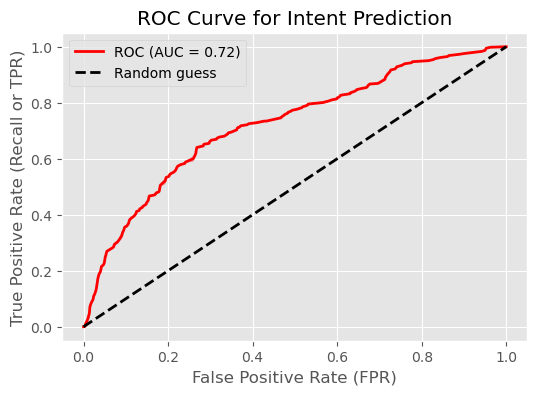

In [446]:
# probabilistic prediction
y_test_proba = logistic_model.predict_proba(X_matrix_test)[:,1] 

# ROC arrays
fprs, tprs, thresholds = roc_curve(y_test, y_test_proba)

# AUC
roc_auc = roc_auc_score(y_test, y_test_proba)

# plot
plt.figure()
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})')  # Corrected line
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')  # Corrected line and added linestyle for clarity

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.title('ROC Curve for Intent Prediction')
plt.legend(loc='best')
plt.show()

Train set accuracy after SMOTE 0.82
Test set accuracy after SMOTE 0.61
Classification Report after SMOTE:
              precision    recall  f1-score   support

           0       0.81      0.62      0.70       798
           1       0.34      0.58      0.43       271

    accuracy                           0.61      1069
   macro avg       0.58      0.60      0.57      1069
weighted avg       0.69      0.61      0.63      1069

Confusion Matrix after SMOTE:
[[495 303]
 [114 157]]


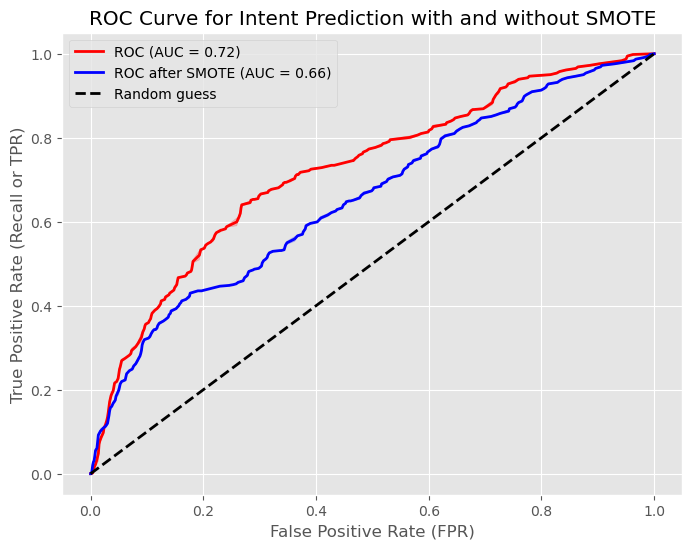

In [447]:
# Logreg with SMOTE

# Initialize the logistic regression model
logistic_model_sm = LogisticRegression(solver='liblinear', max_iter=1000)

# Fit the model on the SMOTE resampled training data
logistic_model_sm.fit(X_train_sm, y_train_sm)

# Evaluate the model on the original training set
print(f"Train set accuracy after SMOTE {logistic_model_sm.score(X_train_sm, y_train_sm):.2f}")

# Evaluate the model on the test set
print(f"Test set accuracy after SMOTE {logistic_model_sm.score(X_matrix_test, y_test):.2f}")

# Make predictions on the test set using the model trained on SMOTE data
test_predictions_sm = logistic_model_sm.predict(X_matrix_test)

# Print classification report
print("Classification Report after SMOTE:")
print(classification_report(y_test, test_predictions_sm))

# Print confusion matrix
print("Confusion Matrix after SMOTE:")
print(confusion_matrix(y_test, test_predictions_sm))

# Get probabilistic predictions
y_test_proba_sm = logistic_model_sm.predict_proba(X_matrix_test)[:,1]

# ROC arrays
fprs_sm, tprs_sm, thresholds_sm = roc_curve(y_test, y_test_proba_sm)

# AUC
roc_auc_sm = roc_auc_score(y_test, y_test_proba_sm)

# Combined Plot
plt.figure(figsize=(8, 6))  # Set the figure size for better visibility
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'ROC (AUC = {roc_auc:0.2f})') # without SMOTE
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
sns.lineplot(x=[0, 1], y=[0, 1], color='black', lw=2, linestyle='--', label='Random guess')

plt.title('ROC Curve for Intent Prediction with and without SMOTE')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (Recall or TPR)')
plt.legend(loc='best')
plt.show()

* The SMOTE technique was applied to reduce imbalance in our dataset ebtween positive and negative classes.  Unfortunately, the SMOTE adjusted data did not result in a better result. Overall, the confidence of the model deteriorated compared to the baseline simple logistric regresison: macro avearges for all indicators (precision, recall, F1) have declined, and the overall test accuracy has declined, too.  

### Simple Logistic Regression - Coefficients

/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_64534/1613680676.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
/var/folders/j6/lnskfknd3zz28plgqdh6w_4m0000gn/T/ipykernel_64534/1613680676.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)


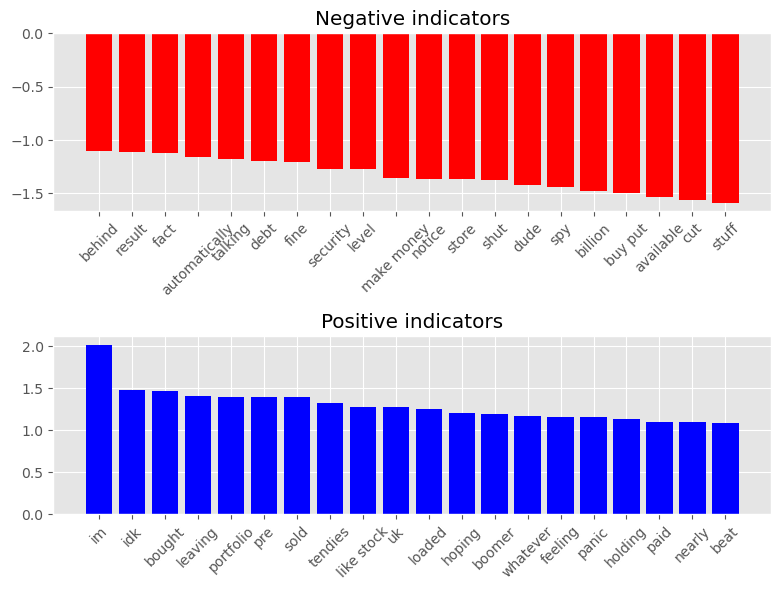

In [448]:
def plot_coefs(model):
    # Create a DataFrame to store the coefficients 
    coef_df = pd.DataFrame({"coefficient": model.coef_[0], "token": count_vectorizer.get_feature_names_out()})
    # Sort by coefficients
    coef_df = coef_df.sort_values("coefficient", ascending=False)

    # Create a figure with 2 subplots
    fig, axs = plt.subplots(2, 1, figsize=(8, 6))

    # Plot tokens with smallest coefficients
    axs[0].bar(coef_df.tail(20)["token"], coef_df.tail(20)["coefficient"], color="red")
    axs[0].set_xticklabels(coef_df.tail(20)["token"], rotation=45)
    axs[0].set_title("Negative indicators")

    # Plot tokens with largest coefficients
    axs[1].bar(coef_df.head(20)["token"], coef_df.head(20)["coefficient"], color="blue")
    axs[1].set_xticklabels(coef_df.head(20)["token"], rotation=45)
    axs[1].set_title("Positive indicators")

    fig.tight_layout()
    plt.show()

plot_coefs(logistic_model)

**Observation:**

* It is aleays useful to see the most important positive and negative word tokens coefficients.  
* Intention to buy stock is associated with words such as "bought", "holding", "morning", "tomorrow", "jumped".  However the positive list is full of words thatnormally do not necessarily show positive intentions to buy securities - many neutral words such as "portfolio", "theater" and even a contraindicating words such as "sold". This suggests that we dont have sufficient number of observations in our dataset. 
* We can see a similar picture with te negative coefficients, indicating lack of intention to buy: negative sentiment can be sensed in words such as "watch", "doubt", 'nah", "worthless". However, the list is full of neutral words such as "store", "yall", "situation", "result", "company", "business". 
* Overall, the review of coefficients suggests that the model has not been sufficiently trained to clearly distinguish positive and negative connotations. 

## 3.4. Gridsearch for logreg

* I use GridSearchCV to search over a specified parameter grid. 
* The GridSearch includes pre-processing steps: vectorisation, dimensionality reduction, logistical regression with various C-factors for regularisation. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [449]:
# Pipeline composition, includes preprocessing and the classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),  # Vectorization
    ('svd', TruncatedSVD(n_components=100)),  # Dimensionality reduction
    ('logr', LogisticRegression(solver='liblinear')) 
])

# Define the hyperparameters to search
param_grid = {
    'tfidf__max_df': [0.8, 0.85, 0.9], # this parameter allows to ignore words that appear in more than XX% of the documents. 
    'tfidf__ngram_range': [(1, 2), (1, 3)], # both unigrams and bigrams will be used as features
    'svd__n_components': [200, 250], # reduce the feature space to the top 100 components
    'logr__C': [10, 100, 200]
}

# Set up GridSearchCV to search for the best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2)

# X_train on the raw text data
grid_search.fit(X_train, y_train)

# After fitting, get the best estimator
best_model = grid_search.best_estimator_

# Predict the test set using the best model
test_predictions = best_model.predict(X_test)

In [450]:
# Calculate the accuracy
test_accuracy = accuracy_score(y_test, test_predictions)

# Print the best hyperparameters
print("Best hyperparameters:", grid_search.best_params_)

# Print the accuracy
print(f"Test Accuracy: {test_accuracy:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test, test_predictions))

# Print confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_test, test_predictions))

Best hyperparameters: {'logr__C': 10, 'svd__n_components': 200, 'tfidf__max_df': 0.9, 'tfidf__ngram_range': (1, 3)}
Test Accuracy: 0.8344
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89       798
           1       0.70      0.60      0.65       271

    accuracy                           0.83      1069
   macro avg       0.79      0.76      0.77      1069
weighted avg       0.83      0.83      0.83      1069

Confusion Matrix:
[[730  68]
 [109 162]]


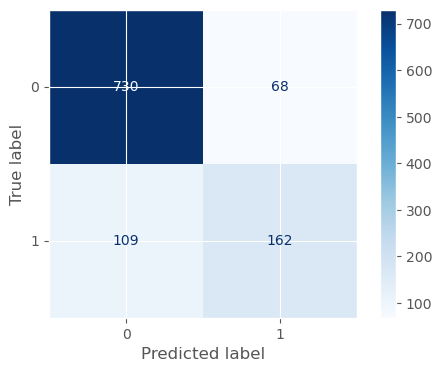

In [451]:
# Confusion matrix
cm = confusion_matrix(y_test, test_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

# Display the confusion matrix with labels
disp.plot(cmap=plt.cm.Blues)
plt.show()

**Model Interpretation:**

* The model has a high true negative rate of 0.89, meaning it is quite effective at identifying the negative cases correctly. 
* The false positive rate of relatively low at 0.11, meaning it doesn't frequently mislabel negative cases as positive.

* However, the true positive rate (Recall) is quite low at 0.40. This means that the model only correctly identifies 40% of the actual positive cases.
* The false negative rate is high at 0.60, indicating that 60% of the positive cases are missed by the model.

* The precision of 0.59 suggests that when the model predicts a case to be positive, it is correct 59% of the time. This is not high, and indicates there is sadly a significant proportion of false positives among the positive predictions.
* The F1 Score is 0.48. This relatively low score. The model is predicting positives only when very sure, and thus missing many actual positive cases.

* The model is cautious, with a tendency to predict negatives, which is likely because o fthe imbalance is data and teh small size of teh dataset. 
* This caution comes at the cost of missing a substantial number of true positives. 
* The model would benefit from adjustments to improve its recall without significantly sacrificing precision, perhaps through using the SMOTE (re-sampling the dataset), or exploring different models.

Below I am importing the best params into a pipeline for export into the big WSB dataset. 

In [452]:
# Importing the best parameters into the pipeline for further export to other notebooks
best_params = grid_search.best_params_

# Create a new pipeline with the best parameters
best_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=best_params['tfidf__max_df'],
                              ngram_range=best_params['tfidf__ngram_range'])),
    ('svd', TruncatedSVD(n_components=best_params['svd__n_components'])),
    ('logr', LogisticRegression(C=best_params['logr__C'], solver='liblinear'))
])

# Fit the best pipeline on the full training set
best_pipeline.fit(X_train, y_train)

# Best_pipeline predictions calculated 
test_predictions = best_pipeline.predict(X_test)

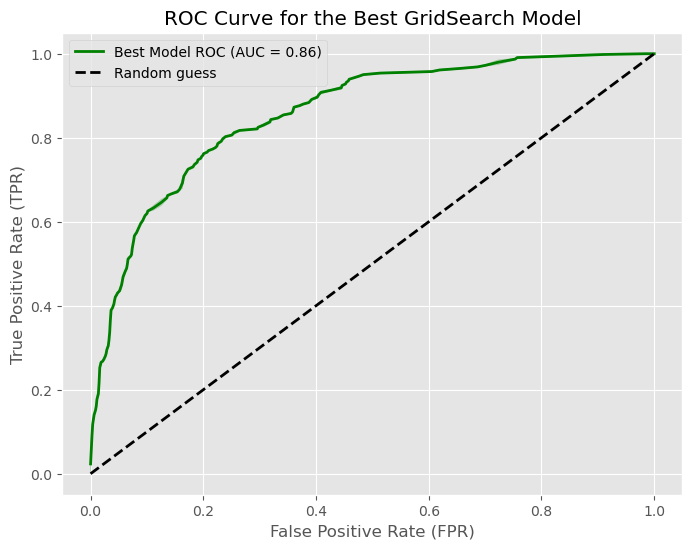

In [453]:
# Predict probabilities for the test set using bets model
y_scores_best = best_pipeline.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for the best model
fprs_best, tprs_best, _ = roc_curve(y_test, y_scores_best)
roc_auc_best = auc(fprs_best, tprs_best)

# Plot the ROC curve for the bext model 
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best, y=tprs_best, color='green', lw=2, label=f'Best Model ROC (AUC = {roc_auc_best:.2f})')
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')
plt.title('ROC Curve for the Best GridSearch Model')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()


####  Plot showing all logistical model regression ROC curves in one chart

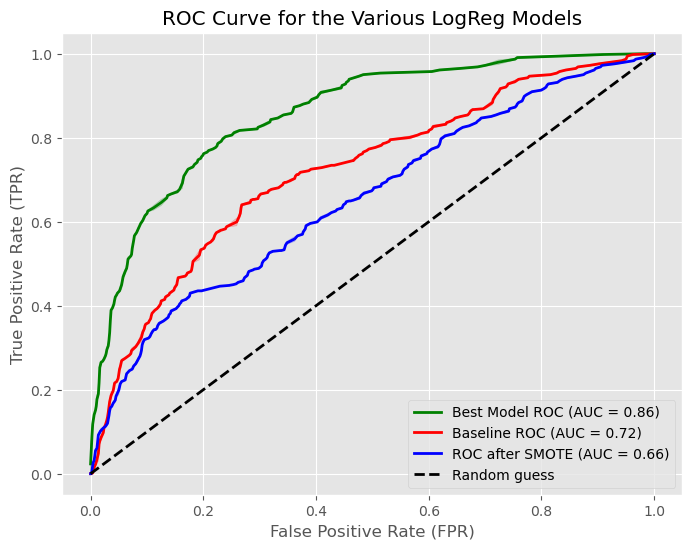

In [454]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
sns.lineplot(x=fprs_best, y=tprs_best, color='green', lw=2, label=f'Best Model ROC (AUC = {roc_auc_best:.2f})') # best model
sns.lineplot(x=fprs, y=tprs, color='red', lw=2, label=f'Baseline ROC (AUC = {roc_auc:0.2f})') # baseline
sns.lineplot(x=fprs_sm, y=tprs_sm, color='blue', lw=2, label=f'ROC after SMOTE (AUC = {roc_auc_sm:0.2f})') # with SMOTE
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random guess')

# Customize the plot
plt.title('ROC Curve for the Various LogReg Models')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='best')
plt.show()

In [455]:
# Save the best model using joblib
# joblib.dump(best_model, "../model/02_labeled_yes_best_linear_grid_search_model.pkl")
# print("Best model saved to '../model/labeled_yes_best_linear_grid_search_model.pkl'")

In [456]:
# Save the best pipline using joblib
from joblib import dump
dump(best_model, '../model/02_labelled_yes_logistic_pipeline.pkl', compress=True)

['../model/02_labelled_yes_logistic_pipeline.pkl']

## 3.5. Decision Tree Classifier

### 3.5.1. Set up a pipeline

In [457]:
# PCA does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [458]:
# Create a pipeline with PCA and a decision tree classifier
pipeline = Pipeline([
    ('pca', PCA()),
    ('clf', DecisionTreeClassifier())
])

In [459]:
# Define the hyperparameters
param_grid = {
    'pca__n_components': [0.8, 0.9],
    'clf__max_depth': [1,2, 3, 5, 7, 10, 15,20], 
    'clf__min_samples_split': [2,3,4,5,6,7,8], 
    'clf__min_samples_leaf': [2,4,5,6,7,8]  
}

### 3.5.2. Hyperparameter optimization

* I use GridSearchCV to search over a specified parameter grid. 
* GridSearchCV will use cross-validation internally, so no need to set up a separate validation set.  

In [460]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5)

In [461]:
# Run the grid search on DT 
grid_search.fit(X_matrix_train_dense, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('pca', PCA(n_components=20)),
                                       ('clf', DecisionTreeClassifier())]),
             param_grid={'clf__max_depth': [1, 2, 3, 5, 7, 10, 15, 20],
                         'clf__min_samples_leaf': [2, 4, 5, 6, 7, 8],
                         'clf__min_samples_split': [2, 3, 4, 5, 6, 7, 8]})

In [462]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__max_depth': 3, 'clf__min_samples_leaf': 4, 'clf__min_samples_split': 5}


### 3.5.3. Parameters to optimize

In [463]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7456


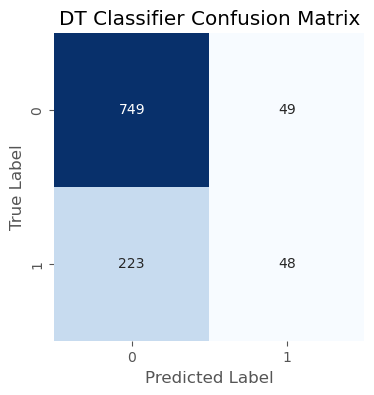

In [464]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DT Classifier Confusion Matrix')
plt.show()

In [465]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       798
           1       0.49      0.18      0.26       271

    accuracy                           0.75      1069
   macro avg       0.63      0.56      0.55      1069
weighted avg       0.70      0.75      0.70      1069



**DT model interpretation**

* The Decision Tree classifier's performance, after hyperparameter tuning and grid search, shows a moderate level of accuracy at 72%, which is lower than the previously constructed logistic regression model's accuracy of 78%. 
* While the model only slightly outperforms the baseline accuracy (majority class prediction is 0 with 73% frequency). The model's ability to classify the positive class (1s) is limited, with a precision of 46% and a notably low recall of 17%. This indicates that while the model is somewhat reliable in predicting the majority class (0s), with a high recall of 93%, it frequently misses the minority class (1s), leading to a substantial number of false negatives. 
* The f1-score for the positive class also shows that the model is conservative in predicting class 1s. 
* Overall, the model is not great at all.  

## 3.6. SVM

This section focuses on implementing a Support Vector Machine model for my dataset. 

In [493]:
from sklearn.datasets import load_iris
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

The code snippets below are adapted from Géron, Aurélien. Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (p. 300). O'Reilly Media. Kindle Edition. 

In [467]:
X = df['Text']
y = df['Intent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99, stratify=y)
X_train.shape

(4272,)

In [468]:
print(y_test.shape)

(1069,)


In [469]:
# Standard Scaling does not support sparse input, converting sparce matrix into a dense matrix
X_matrix_train_dense = X_matrix_train.toarray()
X_matrix_test_dense = X_matrix_test.toarray()

In [470]:
X_matrix_test = count_vectorizer.transform(X_test)
X_matrix_test.shape

(1069, 1000)

First, let's try to fit a linear SVM model:

In [485]:
# Use StandardScaler with with_mean=False
svm_clf = make_pipeline(StandardScaler(with_mean=False),
                        LinearSVC(C=1, random_state=99, dual=False, max_iter=1000000))

# Fit the model
svm_clf.fit(X_matrix_train_dense, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('linearsvc',
                 LinearSVC(C=1, dual=False, max_iter=1000000,
                           random_state=99))])

In [486]:
cross_val_score(svm_clf, X_matrix_train, y_train).mean()

0.7111442540778175

Next, I am trying a more complex  polynomial model  to see if this helps to mporve accuracy:

In [487]:
from sklearn.svm import SVC

poly_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="poly", degree=3, coef0=1, C=5))
poly_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=5, coef0=1, kernel='poly'))])

In [488]:
cross_val_score(poly_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7277636714737664

The accuracy score improved a bit, but it is sitll not as high as some other models applied before.  
Let's try to fit a Radial Basis Function kernel: 

In [489]:
rbf_kernel_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                    SVC(kernel="rbf", gamma=5, C=0.001))

rbf_kernel_svm_clf.fit(X_matrix_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('svc', SVC(C=0.001, gamma=5))])

In [490]:
cross_val_score(rbf_kernel_svm_clf, X_matrix_train, y_train).mean()

0.7467230918827124

The accuracy is even better with the RBF vector.  
Next, I will search for the best SVM model by optimising hyperparameters using gridsearch function:

In [491]:
# Define the hyperparameters
param_grid = [
    {'svc__kernel': ['rbf'],
     'svc__gamma': [0.1, 1, 5, 10],
     'svc__C': [0.001, 0.01, 0.1, 1, 10]},
    {'svc__kernel': ['linear'],
     'svc__C': [0.001, 0.01, 0.1, 1]},
    {'svc__kernel': ['poly'],
     'svc__degree': [2, 3, 4],
     'svc__C': [0.001, 0.01, 0.1, 1, 10],
     'svc__coef0': [0, 1, 10]}
]

In [492]:
# Create the pipeline
final_svm_clf = make_pipeline(StandardScaler(with_mean=False),
                                   SVC())

# Create the GridSearchCV object
grid_search = GridSearchCV(final_svm_clf, param_grid, cv=5,
                           scoring='accuracy', verbose=2)

# Fit the GridSearchCV object
grid_search.fit(X_matrix_train, y_train)

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.7s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.7s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.7s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.7s
[CV] END ......svc__C=0.001, svc__gamma=0.1, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=1, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=5, svc__kernel=rbf; total time=   0.7s
[CV] END ........svc__C=0.001, svc__gamma=5, sv

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('standardscaler',
                                        StandardScaler(with_mean=False)),
                                       ('svc', SVC())]),
             param_grid=[{'svc__C': [0.001, 0.01, 0.1, 1, 10],
                          'svc__gamma': [0.1, 1, 5, 10],
                          'svc__kernel': ['rbf']},
                         {'svc__C': [0.001, 0.01, 0.1, 1, 10],
                          'svc__kernel': ['linear']},
                         {'svc__C': [0.001, 0.01, 0.1, 1, 10],
                          'svc__coef0': [0, 1, 10], 'svc__degree': [2, 3, 4],
                          'svc__kernel': ['poly']}],
             scoring='accuracy', verbose=2)

In [496]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'svc__C': 0.001, 'svc__kernel': 'linear'}


In [497]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7624


In [498]:
print(X_matrix_test_dense.shape)
print(y_test.shape)

(1069, 1000)
(1069,)


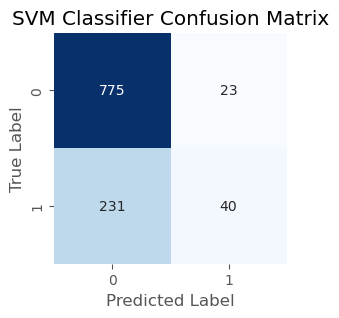

In [499]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Classifier Confusion Matrix')
plt.show()

In [500]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.77      0.97      0.86       798
           1       0.63      0.15      0.24       271

    accuracy                           0.76      1069
   macro avg       0.70      0.56      0.55      1069
weighted avg       0.74      0.76      0.70      1069



## 3.7. Random Forest Model

In [506]:
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier

random_forest_model = RandomForestClassifier(n_estimators=500)
random_forest_model.fit(X_matrix_train_dense, y_train)

RandomForestClassifier(n_estimators=500)

In [507]:
# Instantiate lists to save scores in
decision_tree_train_scores = []
decision_tree_test_scores = []
# For each tree, score on train and test
for sub_tree in random_forest_model.estimators_:
    decision_tree_train_scores.append(sub_tree.score(X_matrix_train_dense, y_train))
    decision_tree_test_scores.append(sub_tree.score(X_matrix_test_dense, y_test))

# Rather than many separate print() statements, we can combine them into one using triple quotes.
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_matrix_train_dense, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_matrix_test_dense, y_test)}
""")


Performance on fitted data:
Average Decision Tree: 0.8824822097378275
Random Forest: 0.9946161048689138
----------------
Performance on test data:
Average Decision Tree: 0.6800093545369504
Random Forest: 0.7595884003741815



In [514]:
# Predictions on test data
y_pred = random_forest_model.predict(X_matrix_test_dense)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print all metrics
print(f"""
Performance on fitted data:
Average Decision Tree: {np.mean(decision_tree_train_scores)}
Random Forest: {random_forest_model.score(X_matrix_train_dense, y_train)}
----------------
Performance on test data:
Average Decision Tree: {np.mean(decision_tree_test_scores)}
Random Forest: {random_forest_model.score(X_matrix_test_dense, y_test)}
Accuracy: {accuracy}
Precision: {precision}
Recall: {recall}
F1 Score: {f1}
Confusion Matrix: 
{conf_matrix}
""")


Performance on fitted data:
Average Decision Tree: 0.8824822097378275
Random Forest: 0.9946161048689138
----------------
Performance on test data:
Average Decision Tree: 0.6800093545369504
Random Forest: 0.7595884003741815
Accuracy: 0.7595884003741815
Precision: 0.7325430448070682
Recall: 0.7595884003741815
F1 Score: 0.7352937640693867
Confusion Matrix: 
[[727  71]
 [186  85]]



The random forest model performs quite well on the test set, better than the average of its component trees.

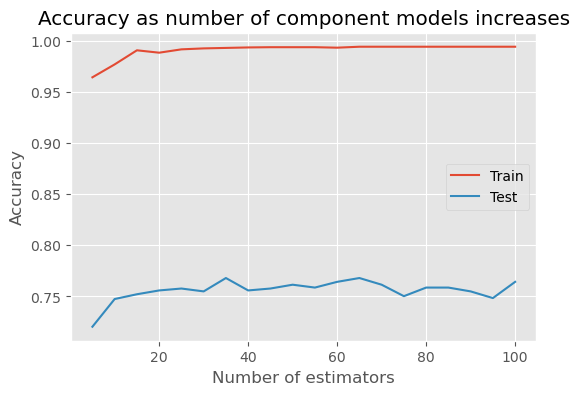

In [529]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

Train set accuracy is improving until approximately 40 components, and stops improviing after that. Test set accuracy seems to be stable with minor variations past 20 components, but seems to be peaking at n=60.  

I will try to experiment with the depth of each tree in the code below:

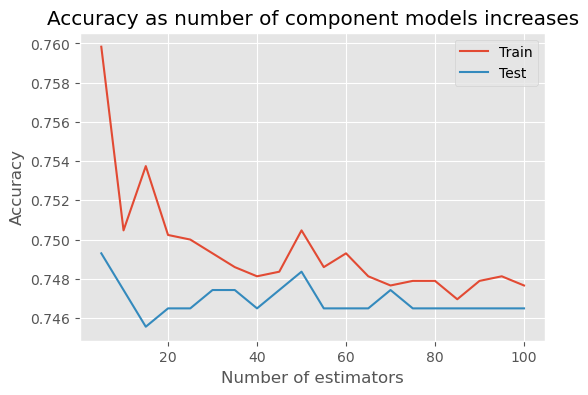

In [528]:
# Observing whether increasing the number of trees in the forest helps to improve accuracy:
train_scores = []
test_scores = []
n_range = range(5, 101, 5)
for n in n_range:
    RF_model = RandomForestClassifier(n_estimators = n,  max_depth = 7)
    RF_model.fit(X_matrix_train_dense, y_train)
    train_scores.append(RF_model.score(X_matrix_train_dense, y_train))
    test_scores.append(RF_model.score(X_matrix_test_dense, y_test))
    
plt.plot(n_range, train_scores, label = 'Train')
plt.plot(n_range, test_scores, label = 'Test')
plt.xlabel("Number of estimators")
plt.ylabel("Accuracy")
plt.title("Accuracy as number of component models increases")
plt.legend();

In [545]:
# Create a pipeline with PCA and a Random Forest
pipeline = Pipeline([
    ('pca', PCA()),
    ('clf', RandomForestClassifier())
])

In [546]:
# Define the hyperparameters
param_grid = {
    'pca__n_components': [0.8, 0.9],
    'clf__n_estimators': [20, 30, 60], 
    'clf__max_depth': [10,20,30,40],
    'clf__max_features': [20,30,40]
}

In [551]:
# Set up GridSearchCV 
grid_search = GridSearchCV(pipeline, param_grid, cv=5, verbose=2)

In [550]:
# Run the grid search on Random Forest 
grid_search.fit(X_matrix_train_dense, y_train)

In [541]:
# Print the best hyperparameters for DT Gridsearch
print("Best hyperparameters:", grid_search.best_params_)

Best hyperparameters: {'clf__max_depth': 40, 'clf__n_estimators': 60, 'pca__n_components': 0.8}


In [542]:
best_model = grid_search.best_estimator_

# Using the dense version of X_test, which is X_matrix_test_dense
test_preds = best_model.predict(X_matrix_test_dense)

# Accuracy using the true labels y_test and the predicted labels test_preds
val_acc = accuracy_score(y_test, test_preds)
print(f"Validation Accuracy with Best Parameters: {val_acc:.4f}")

Validation Accuracy with Best Parameters: 0.7568


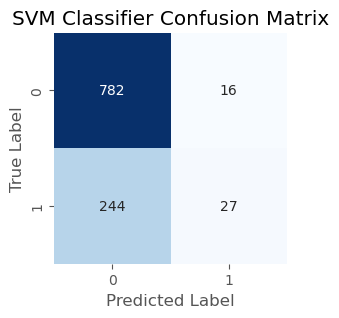

In [543]:
matrix = confusion_matrix(y_test, test_preds)

# Displaying the confusion matrix 
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(3, 3))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('SVM Classifier Confusion Matrix')
plt.show()

In [544]:
# Printing the classification report
report = classification_report(y_test, test_preds)
print(report)

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       798
           1       0.63      0.10      0.17       271

    accuracy                           0.76      1069
   macro avg       0.70      0.54      0.51      1069
weighted avg       0.73      0.76      0.68      1069

